In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

## 5.5 Parâmetros intrínsecos

In [2]:
caminhos_capturas = glob.glob("pmr3502-captura-de-imagens/capturas/*.jpg")
caminhos_capturas[:3]

['pmr3502-captura-de-imagens/capturas/capturah9c7pmth.jpg',
 'pmr3502-captura-de-imagens/capturas/capturam5axvoee.jpg',
 'pmr3502-captura-de-imagens/capturas/captura1i_o036j.jpg']

In [3]:
dim = (6,6)
pontos_imagem = []
rotulos = []
imagens = []
imagens_cinza = []
CALIB_OPTIONS = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_LARGER + cv2.CALIB_CB_MARKER

# Para todas as imagens, extrai as coordenadas dos cantos do padrão de calibração
for caminho in caminhos_capturas:
  imagem = cv2.imread(caminho)
  imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
  ret, corners, meta = cv2.findChessboardCornersSBWithMeta(imagem_cinza, dim, CALIB_OPTIONS)
  if ret:
    pontos_imagem.append(corners)
    rotulos.append(meta)
    imagens.append(imagem)
    imagens_cinza.append(imagem_cinza)

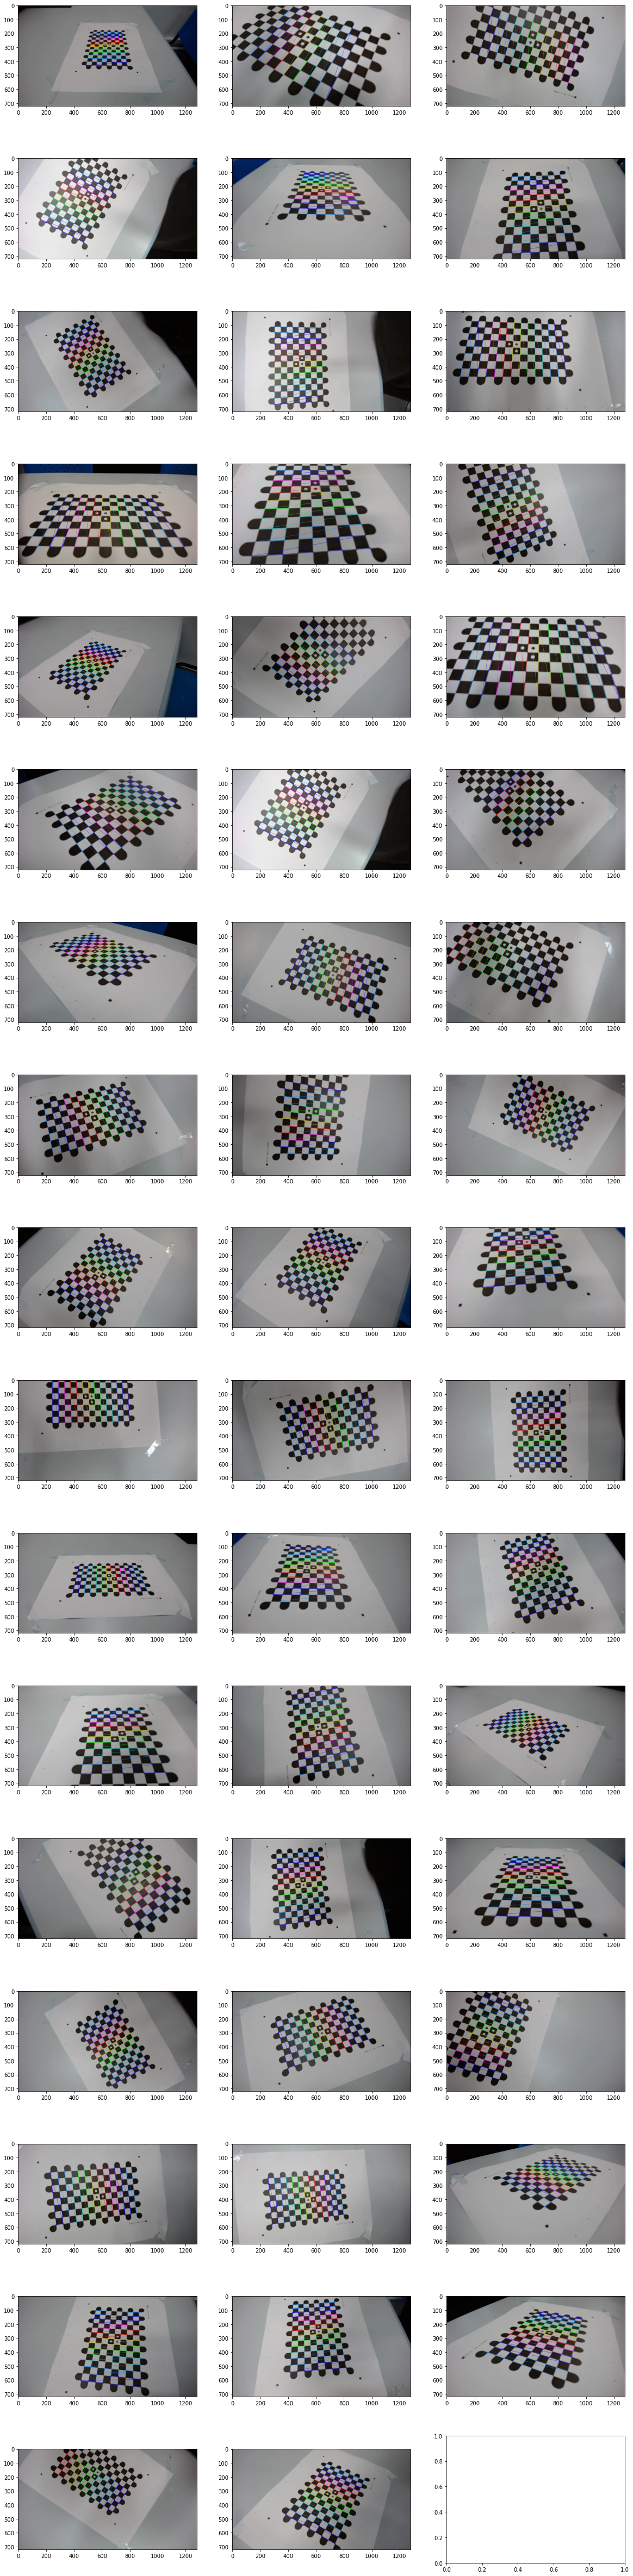

In [4]:
# Exibe os padrões de calibração com os cantos desenhados

cols = 3
lines = (len(imagens)+cols-1)//cols
fig, axes = plt.subplots(lines, cols, figsize=(2+6*cols,5*lines+2))
for i, c in enumerate(pontos_imagem):
    imagem = np.array(imagens[i])
    cv2.drawChessboardCorners(imagem, rotulos[i].shape, c, True)
    if lines > 1:
        axes[i//cols, i%cols].imshow(imagem)
    else:
        axes[i%cols].imshow(imagem)

In [5]:
pontos_mundo = []
for i, c in enumerate(pontos_imagem):
    l,a = rotulos[i].shape
    vp = []
    for n in range(l*a):
        vp.append([n//a,n%a,0])
    pontos_mundo.append(np.array(vp, dtype=np.float32))

In [6]:
apret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(np.array(pontos_mundo)
,pontos_imagem,(1280, 720), None, None)

<ipython-input-6-9d0e5980bbcf>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(np.array(pontos_mundo)


In [7]:
mtx

array([[772.05629684,   0.        , 634.16050528],
       [  0.        , 771.97789148, 366.58170894],
       [  0.        ,   0.        ,   1.        ]])

In [8]:
dist

array([[ 0.09359021, -0.22813258,  0.00026009, -0.00095021,  0.09884936]])

In [9]:
erro_total = 0
for i in range(len(pontos_mundo)):
    imgpoints2, _ = cv2 . projectPoints(pontos_mundo[i], rvecs[i], tvecs[i], mtx, dist)
    erro = cv2 . norm(pontos_imagem[i], imgpoints2, cv2 . NORM_L2)/len(imgpoints2)
    erro_total += erro
    erro_medio = erro_total/len(pontos_mundo)
print(erro_medio)

0.03442665111907727


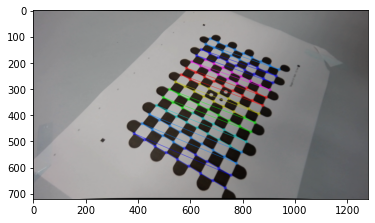

In [10]:
im = cv2.undistort(imagem, mtx , dist)
plt.imshow(im)

## 5.6 Parâmetros extrínsecos

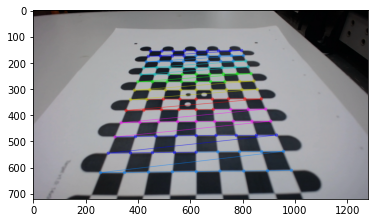

In [11]:
# imagem_extrinseca = cv2.imread("./pmr3502-captura-opencv-notebook/extrinseca_10-06.jpg")
imagem_extrinseca = cv2.imread("../images/quadriculado_v2.jpg")
imagem_extrinseca_cinza = cv2.cvtColor(imagem_extrinseca, cv2.COLOR_BGR2GRAY)
ret, corners, meta = cv2.findChessboardCornersSBWithMeta(imagem_extrinseca_cinza, dim, CALIB_OPTIONS)

if ret:
    cv2.drawChessboardCorners(imagem_extrinseca, meta.shape, corners, True)
    plt.imshow(imagem_extrinseca)

In [12]:
#construindo o vetor de coordenadas globais:
#coordenadas_globais
coords_globais = []
DIST = 12.1
x_central = 297.0/2
y_central = 0.0

for x in range(-6, 7, 1):
    for y in range(4, -5, -1):
        coords_globais.append((x_central+(x*DIST), y_central-(y*DIST), 0.0))
len(coords_globais)

117

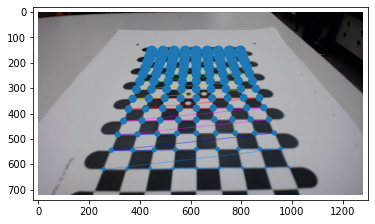

In [13]:
# gambiarrona pra conferir a ordem dos pontos
c_x = corners[:,0][:,0]
c_y = corners[:,0][:,1]
size = np.arange(117, 0, -1)
plt.scatter(c_x, c_y, s=size)
plt.xlim(-20, 1300)
plt.ylim(740, -20)
plt.imshow(imagem_extrinseca)
plt.show()

In [14]:
ret, rot, trans = cv2.solvePnP(np.array(coords_globais), corners, mtx, dist)

In [15]:
print(coords_globais[0])
print(coords_globais[-1])

(75.9, -48.4, 0.0)
(221.1, 48.4, 0.0)


In [16]:
corners[0]

array([[447.68207, 155.89542]], dtype=float32)

In [37]:
trans

array([[-1.57344933],
       [80.92147334],
       [44.30539103]])

In [38]:
rot

array([[ 1.70225617],
       [-1.6599105 ],
       [ 0.79778074]])

In [39]:
# Rodriiiiigues
matriz_rot, jacobiano = cv2.Rodrigues(rot)

In [40]:
matriz_rot

array([[ 0.02615377, -0.99965591, -0.00201007],
       [-0.62292082, -0.01472463, -0.7821463 ],
       [ 0.78184757,  0.02170819, -0.62309159]])

## 5.7 Projeção de pontos e realidade aumentada

In [21]:
G = np.eye(4)
G[0:3,0:3] = matriz_rot
G[0:3,3] = trans.T
pl = [297.0/2, 0.0, 0.0, 1.0]

In [22]:
# fazendo a projeçao usando multiplicação de matrizes:
p = mtx@np.c_[np.eye(3),np.zeros((3,1))]@G@pl
p = p/p[2]
p

array([645.27224136, 310.84481901,   1.        ])

In [23]:
# fazendo a projeção com a função do opencv:
coords_projetadas, jac = cv2.projectPoints(np.array([pl[:3]]),rot,trans,mtx,dist)
coords_projetadas

array([[[645.27308103, 310.82174039]]])

In [31]:
# com isso, construímos uma função que já tem todas as informações de calibração embutidas
# a função recebe uma lista de pontos na referência global e devolve ela na referência da câmera
def global2camera(coords_globais):
    rot = np.array([[ 1.70225617], [-1.6599105 ], [ 0.79778074]])
    trans = np.array([[-1.57344933], [80.92147334], [44.30539103]])
    mtx = np.array([[772.07218515,   0.        , 634.15206573],
                    [  0.        , 771.9959048 , 366.5862172 ],
                    [  0.        ,   0.        ,   1.        ]])
    dist = np.array([[ 0.09361794, -0.22823167,  0.00027023, -0.00095334,  0.09892737]])
    coords_projetadas, jac = cv2.projectPoints(np.array(coords_globais),rot,trans,mtx,dist)
    
    # coords_projetadas tem um formato indesejável, fazemos uma conversão
    coords_camera = []
    for c_p in coords_projetadas:
        coords_camera.append([int(c_p[0][0]), int(c_p[0][1])])
    
    return coords_camera, jac

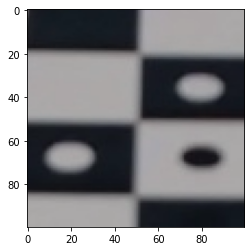

In [32]:
imagem_extrinseca = cv2.imread("extrinseca_10-06.jpg")
ponto_x = int(p[0])
ponto_y = int(p[1])
d = 50
plt.imshow(imagem_extrinseca[ponto_y-d:ponto_y+d, ponto_x-d:ponto_x+d])

In [33]:
# criando os pontos do cubo no sistema de coordenadas globais

centro = [297.0/2, 0.0, 0.0]
a = 12.1 # aresta do quadrado do padrão

cubo_global = []
cubo_global.append([centro[0]-a, centro[1]-a, centro[2]])
cubo_global.append([centro[0]+a, centro[1]-a, centro[2]])
cubo_global.append([centro[0]+a, centro[1]+a, centro[2]])
cubo_global.append([centro[0]-a, centro[1]+a, centro[2]])
cubo_global.append([centro[0]-a, centro[1]-a, centro[2]+2*a])
cubo_global.append([centro[0]+a, centro[1]-a, centro[2]+2*a])
cubo_global.append([centro[0]+a, centro[1]+a, centro[2]+2*a])
cubo_global.append([centro[0]-a, centro[1]+a, centro[2]+2*a])
cubo_global

[[136.4, -12.1, 0.0],
 [160.6, -12.1, 0.0],
 [160.6, 12.1, 0.0],
 [136.4, 12.1, 0.0],
 [136.4, -12.1, 24.2],
 [160.6, -12.1, 24.2],
 [160.6, 12.1, 24.2],
 [136.4, 12.1, 24.2]]

In [34]:
# transformar as coordenadas globais do cubo em coordenadas da câmera

cubo_camera, jac = global2camera(cubo_global)
cubo_camera

[[706, 346],
 [701, 280],
 [591, 278],
 [582, 345],
 [714, 236],
 [707, 176],
 [586, 175],
 [576, 234]]

In [35]:
# criando as setas indicadoras de coordenadas
centro_setas = [centro[0]-6*a, centro[1]-4*a, 0.0]

setas_global = []
setas_global.append(centro_setas)
setas_global.append([centro_setas[0]+2*a, centro_setas[1], centro_setas[2]])
setas_global.append([centro_setas[0], centro_setas[1]+2*a, centro_setas[2]])
setas_global.append([centro_setas[0], centro_setas[1], centro_setas[2]+2*a])

# transformando as coordenadas globais das setas em coordenadas da câmera
setas_camera, jac = global2camera(setas_global)

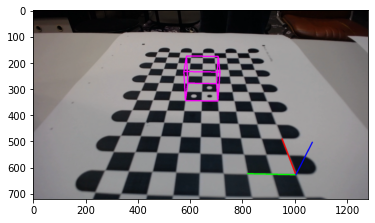

In [36]:
# desenhando o cubo e setas na imagem
im = np.copy(imagem_extrinseca)
cor = [255, 0, 255] # magenta
espessura = 4

# quadrado inferior
cv2.line(im, cubo_camera[0], cubo_camera[1], cor, espessura)
cv2.line(im, cubo_camera[1], cubo_camera[2], cor, espessura)
cv2.line(im, cubo_camera[2], cubo_camera[3], cor, espessura)
cv2.line(im, cubo_camera[3], cubo_camera[0], cor, espessura)

# arestas verticais
cv2.line(im, cubo_camera[0], cubo_camera[4], cor, espessura)
cv2.line(im, cubo_camera[1], cubo_camera[5], cor, espessura)
cv2.line(im, cubo_camera[2], cubo_camera[6], cor, espessura)
cv2.line(im, cubo_camera[3], cubo_camera[7], cor, espessura)

# quadrado superior
cv2.line(im, cubo_camera[4], cubo_camera[5], cor, espessura)
cv2.line(im, cubo_camera[5], cubo_camera[6], cor, espessura)
cv2.line(im, cubo_camera[6], cubo_camera[7], cor, espessura)
cv2.line(im, cubo_camera[7], cubo_camera[4], cor, espessura)

#setas
cv2.line(im, setas_camera[0], setas_camera[1], [255, 0, 0], espessura)
cv2.line(im, setas_camera[0], setas_camera[2], [0, 255, 0], espessura)
cv2.line(im, setas_camera[0], setas_camera[3], [0, 0, 255], espessura)

plt.imshow(im)